In [21]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.stats import entropy, wasserstein_distance, truncnorm, pearson3, entropy
import emcee
from tqdm import tqdm
import scipy.stats as sp
from matplotlib import cm
from matplotlib.colors import Normalize
mpl.rcParams['figure.dpi'] = 300

class RainDataSampler:
    def __init__(self, category, sample_size):
        self.file_path = f'/Users/braydennoh/Downloads/StatSed/dischargedata/riocaonillas/{category}.txt'
        self.sample_size = sample_size

    def read_data(self):
        max_values_m = []
        with open(self.file_path, 'r') as file:
            max_values_m = [float(line.strip()) for line in file.readlines()]

        start_year = 1989
        year_range = list(range(start_year, start_year + len(max_values_m)))
        result_df = pd.DataFrame({'Year': year_range, 'Max_Value_m': max_values_m})
        sort_rain = result_df.sort_values(by=['Max_Value_m'], ascending=False).reset_index(drop=True)

        rank = np.zeros((len(sort_rain), 3))
        for i in range(len(sort_rain)):
            rank[i, 0] = i + 1
            rank[i, 1] = (i + 1)/(len(sort_rain)+1)
            rank[i, 2] = 1/rank[i, 1]

        rank_df = pd.DataFrame(rank, columns=['rank', 'probability', 'return_year'])
        rank_df[['rank', 'return_year']] = rank_df[['rank', 'return_year']].astype(int)
        self.rank_rain = pd.concat([sort_rain, rank_df], axis=1)

    def sample_log_pearson(self):
        self.read_data()
        rain = np.array(self.rank_rain['Max_Value_m'])
        std = np.std(rain)
        u = np.mean(rain)
        skew = sp.skew(np.log10(rain))
        re_year = np.array(self.rank_rain['return_year'])

        z = np.zeros(len(re_year))
        k3 = np.zeros(len(re_year))
        lp3 = np.zeros(len(re_year))

        for i in range(len(k3)):
            if re_year[i] != 1:
                z[i] = sp.norm.ppf(1-(1/re_year[i]))
                k3[i] = -(np.sqrt(6)/np.pi)*(0.5772 + np.log(np.log(re_year[i]/(re_year[i]-1))))
            else:
                z[i] = sp.norm.ppf(1-(1/(re_year[i]+0.1)))
                k3[i] = -(np.sqrt(6)/np.pi)*(0.5772 + np.log(np.log((re_year[i]+0.1)/(re_year[i]+0.1-1))))
            lp3[i] = 2/skew * (np.power((z[i] - skew/6)*skew/6+1, 3)-1)
        
        model_rain = np.zeros((len(rain), 3))
        for i in range(len(model_rain)):
            model_rain[i][0] = u + z[i]* std
            model_rain[i][1] = u + k3[i] * std
            model_rain[i][2] = np.power(10, np.mean(np.log10(rain)) + lp3[i] * np.std(np.log10(rain)))

        pd_rain = pd.DataFrame(model_rain, columns=['Normal', 'Gumbel', 'LogPerason'])
        rank = self.rank_rain['probability']
        sampled_log_pearson = pd_rain['LogPerason'].sample(n=self.sample_size, weights=rank, replace=True, random_state=1)
        sampled_array = sampled_log_pearson.to_numpy()
        
        return sampled_array

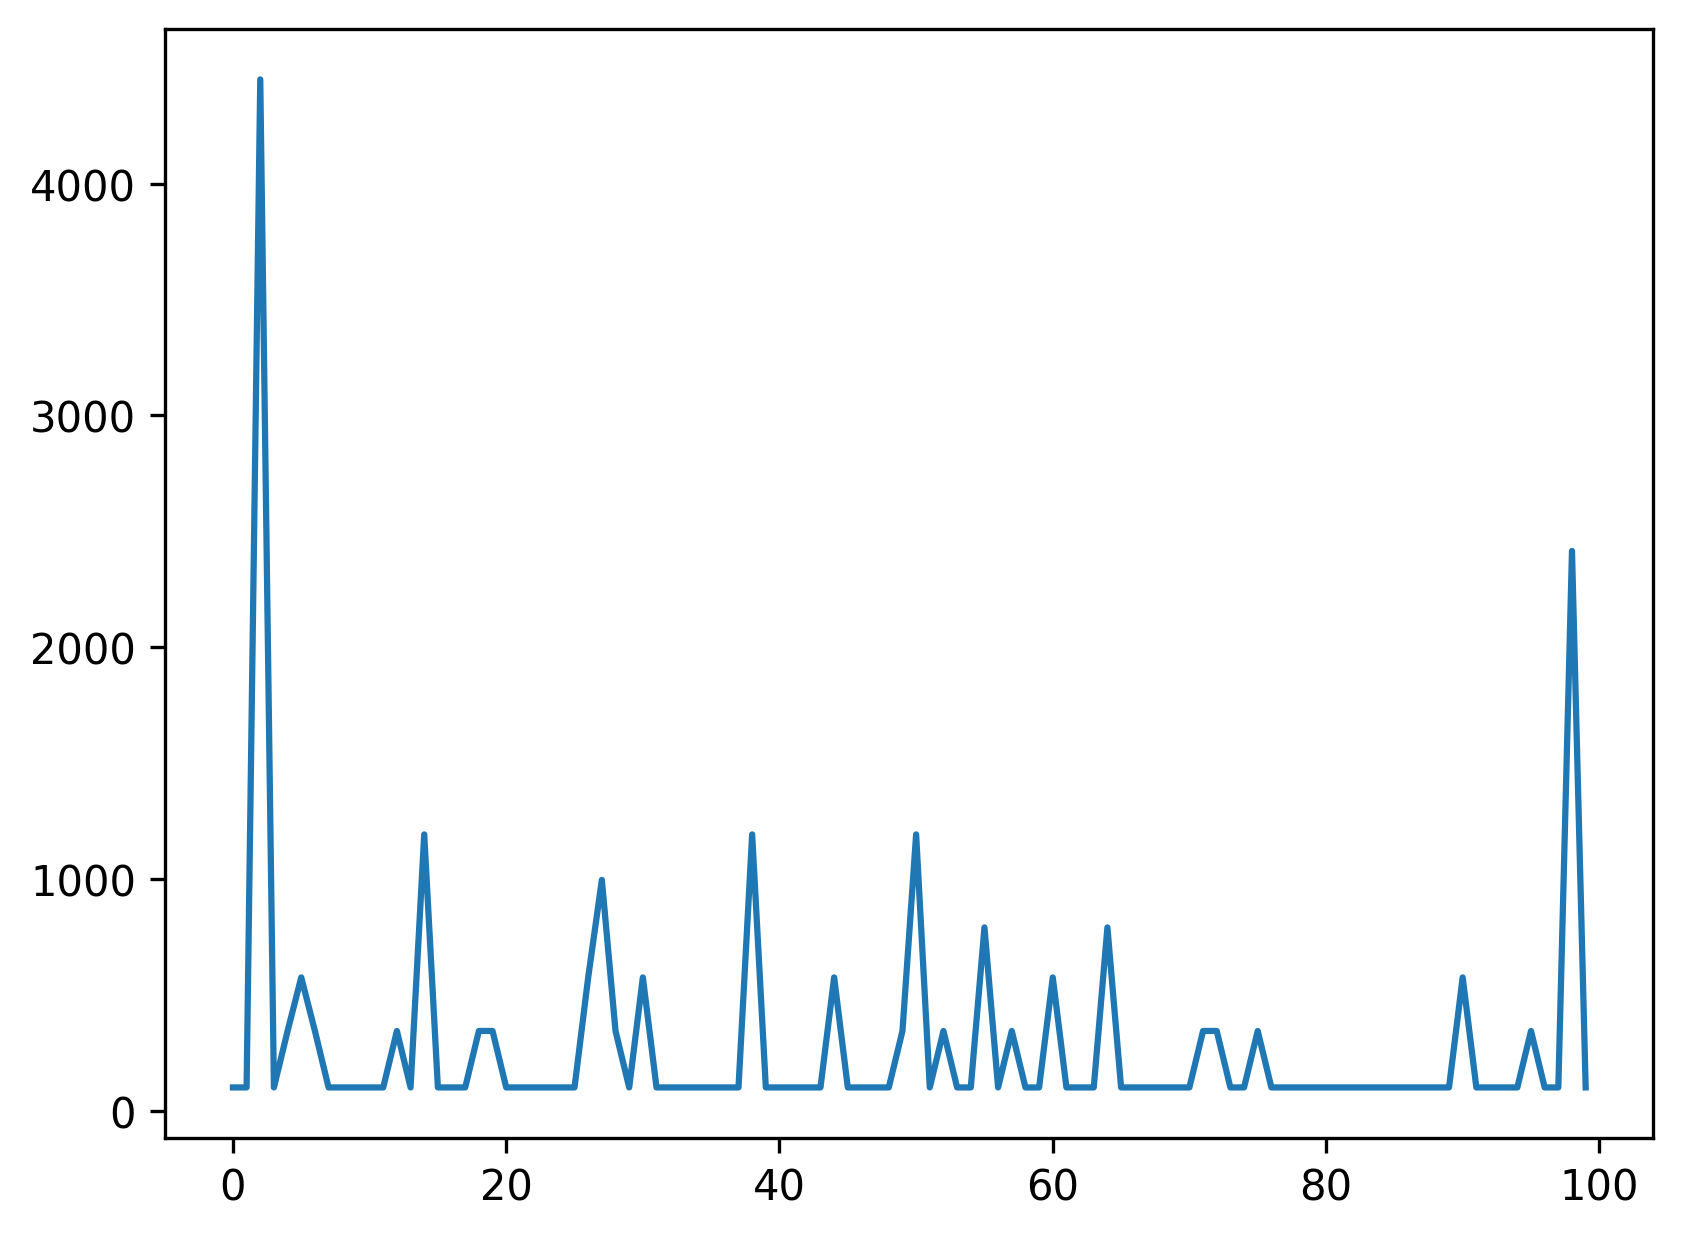

In [28]:
category = "veryhigh"
sample_size = 100

sampler = RainDataSampler(category, sample_size)
sampled_array = sampler.sample_log_pearson()
plt.plot(sampled_array)
len(sampled_array)

mediandiameter = 1
def hkm(input_shear_stress_array):
    total_sediments = 100000
    diameters = np.random.uniform(0.01, 2.00, total_sediments)
    shield = 0.05
    specificg = 2
    scaled_r_values = [shield * (specificg - 1) * 1000 * 9.8 * r for r in diameters]
    x_coordinates = np.random.uniform(-1000, 0, total_sediments)
    y_coordinates = np.random.uniform(0, 10, total_sediments)
    x_coordinates_all_iterations = []
    y_coordinates_all_iterations = []

    for iteration, input_shear_stress in tqdm(enumerate(input_shear_stress_array), total=len(input_shear_stress_array)):
        move_indices = np.where(np.array(scaled_r_values) < input_shear_stress)[0]
        move_diameters = np.array(diameters)[move_indices]
        diameterratio = move_diameters/mediandiameter
        L_values = 1.77 * (1 - np.log10(diameterratio))**1.35
        Distance = L_values
        x_coordinates[move_indices] += Distance
        x_coordinates_all_iterations.append(x_coordinates.copy())
        y_coordinates_all_iterations.append(y_coordinates.copy())

    return input_shear_stress_array, x_coordinates_all_iterations, y_coordinates_all_iterations, diameters

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 310.20it/s]


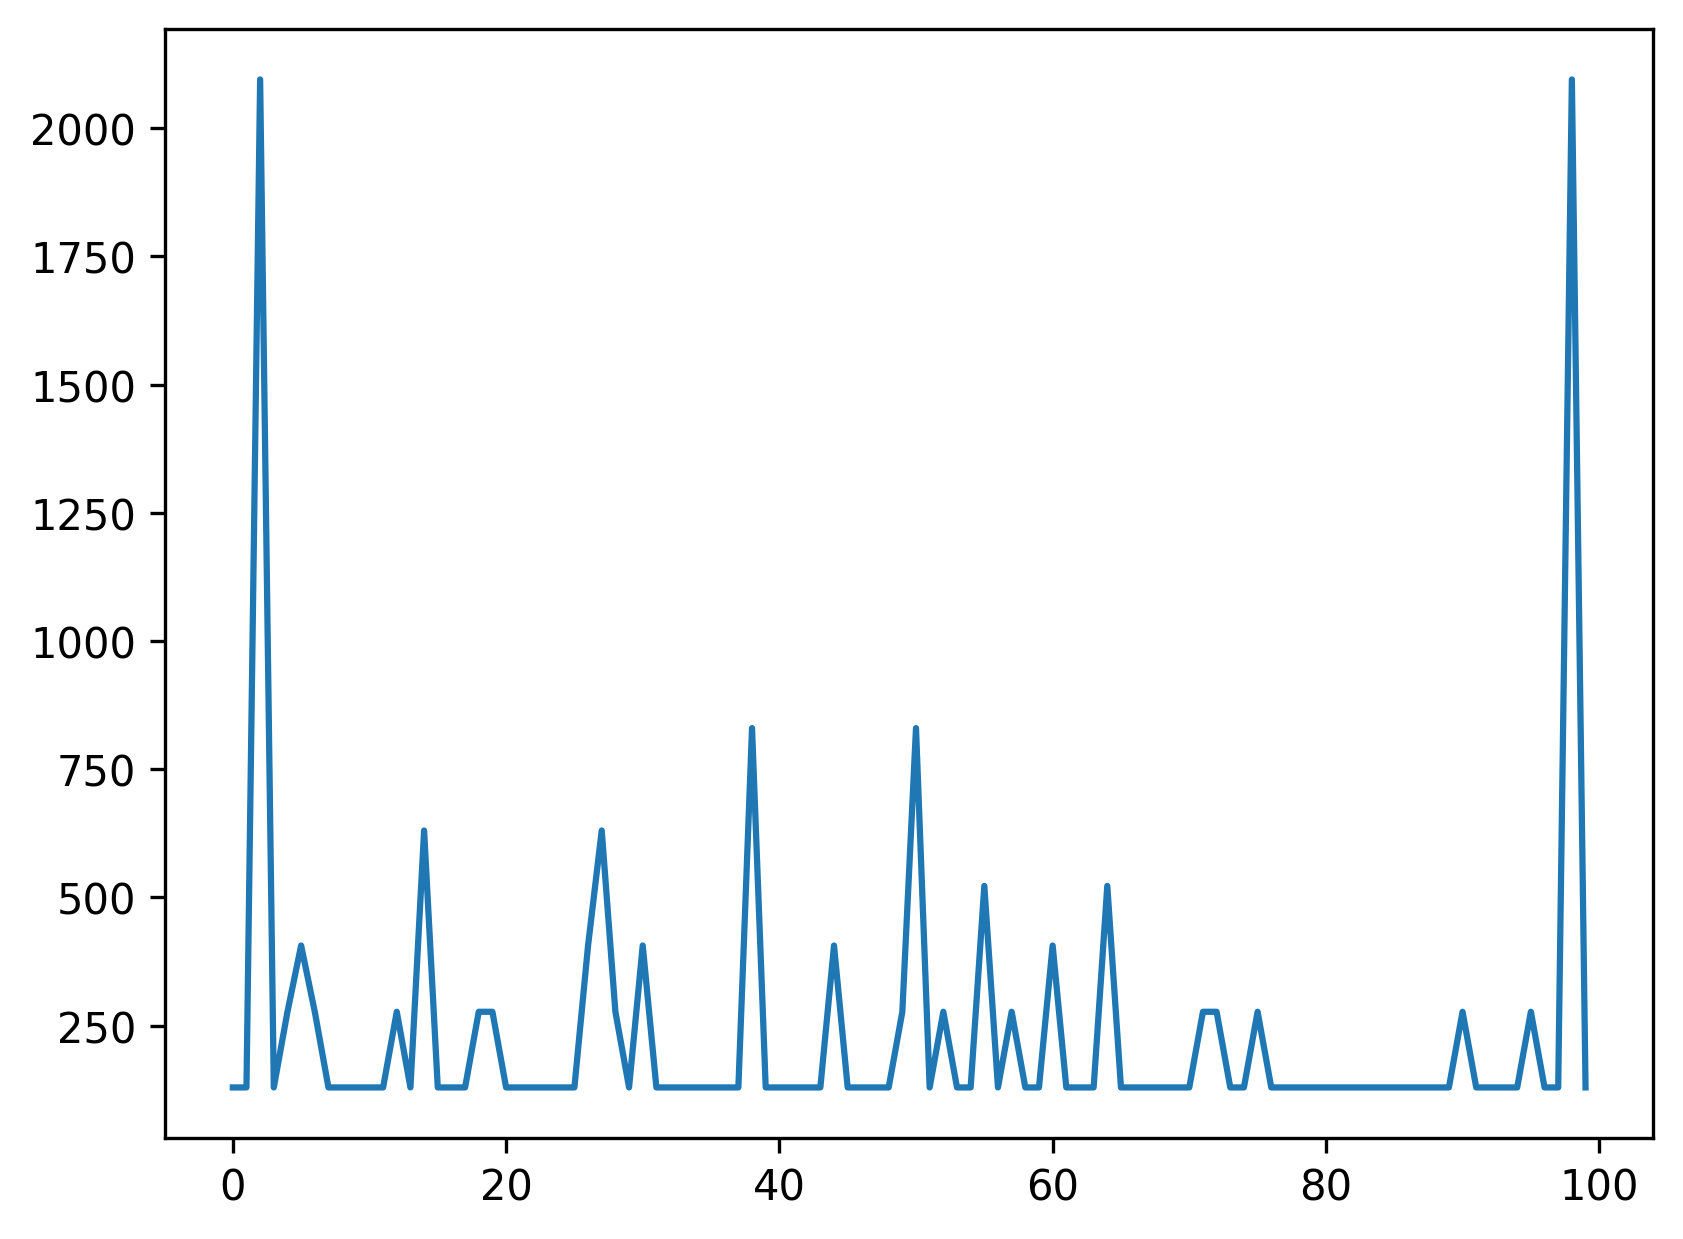

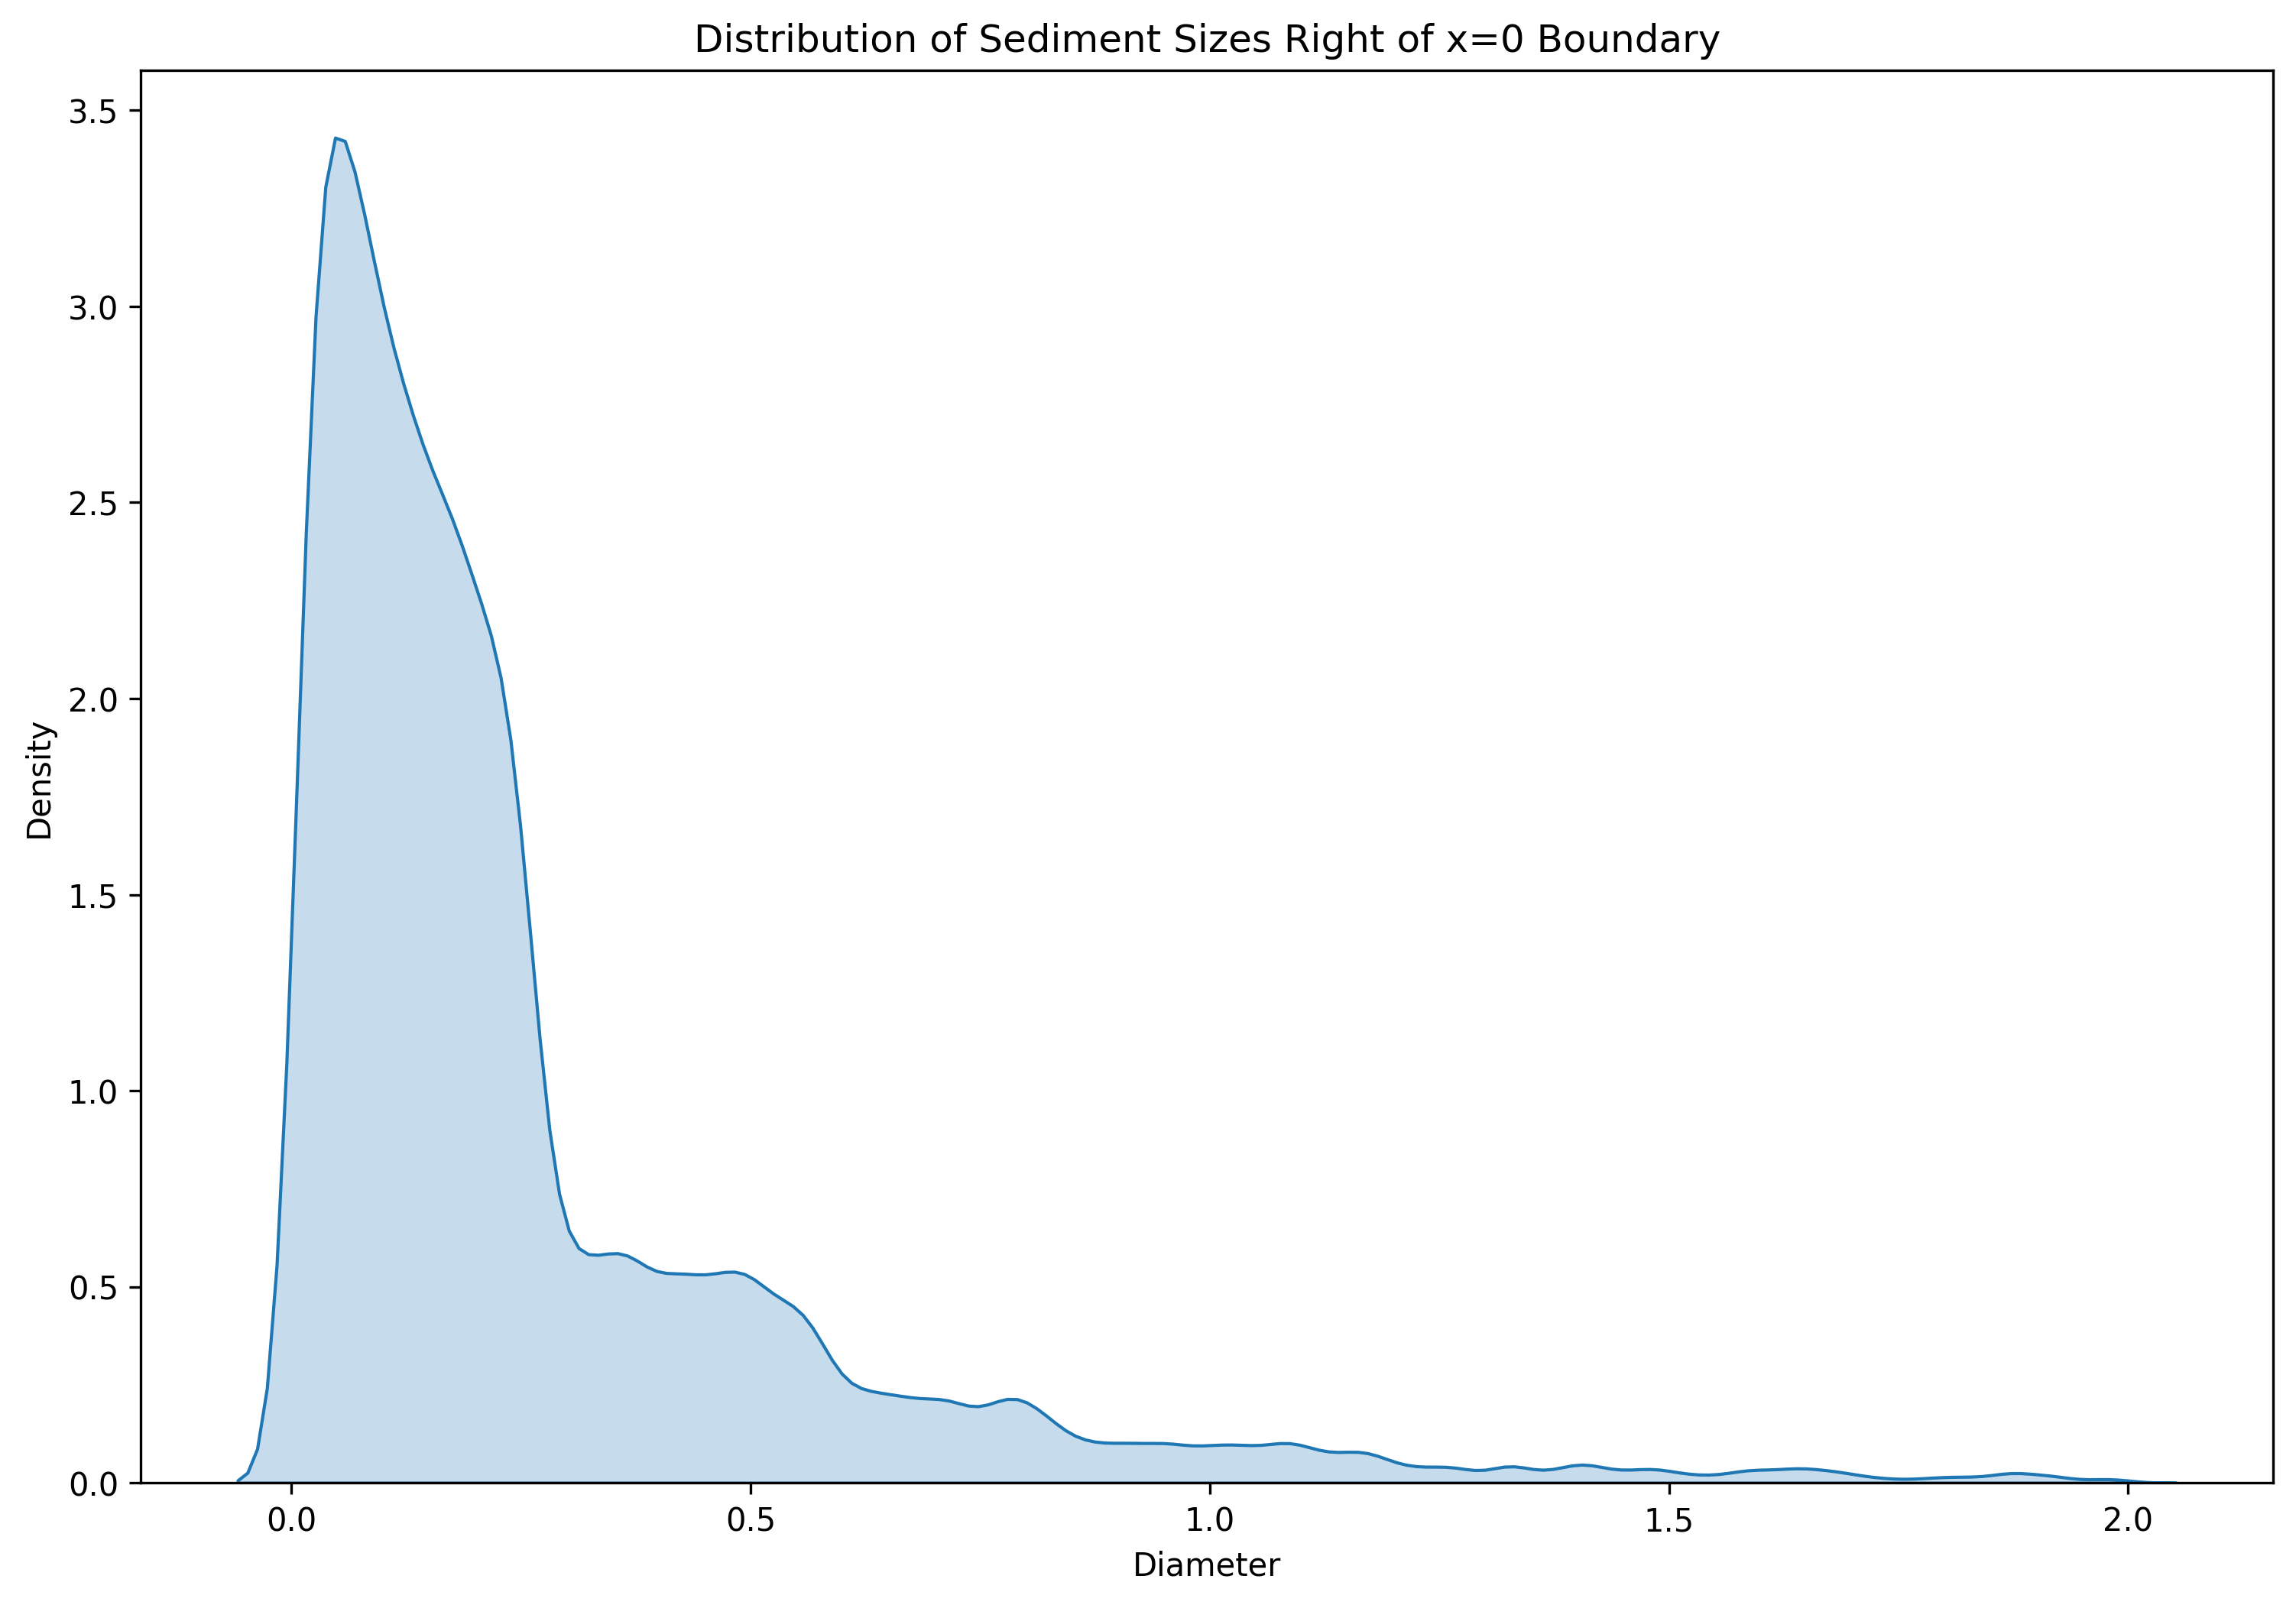

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

category = "medium"
sample_size = 100

sampler = RainDataSampler(category, sample_size)
sampled_array = sampler.sample_log_pearson()
plt.plot(sampled_array)
len(sampled_array)

_, x_coordinates_all_iterations, _, diameters = hkm(sampled_array) # Note the change here

# Concatenating all the x coordinates across iterations and filtering diameters
filtered_diameters = []

for x_iter in x_coordinates_all_iterations:
    filtered_diameters.extend([d for x, d in zip(x_iter, diameters) if x > 0])

# Creating a DataFrame for seaborn
import pandas as pd
data = pd.DataFrame({'Diameter': filtered_diameters})

# Plotting the KDE plot for diameters
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data, x='Diameter', fill=True)
plt.title('Distribution of Sediment Sizes Right of x=0 Boundary')
plt.xlabel('Diameter')
plt.ylabel('Density')
plt.show()

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.27it/s]


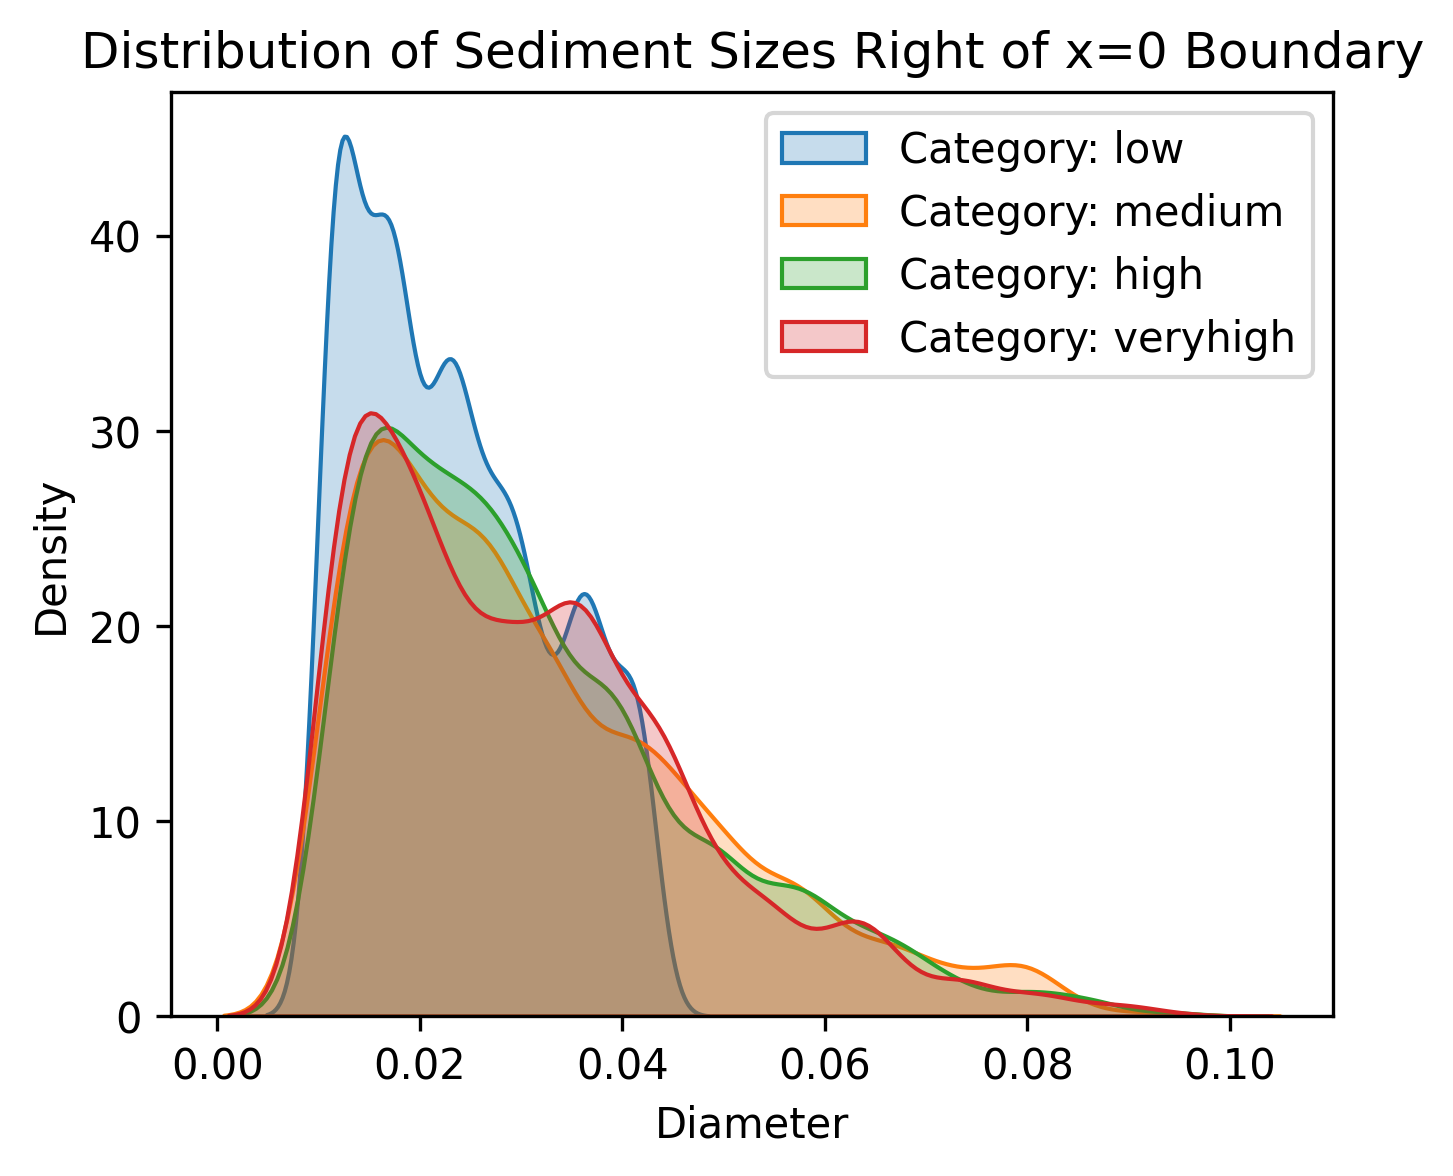

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_filtered_diameters(category, sample_size):
    sampler = RainDataSampler(category, sample_size)
    sampled_array = sampler.sample_log_pearson()
    
    _, x_coordinates_all_iterations, _, diameters = hkm(sampled_array)
    
    filtered_diameters = []
    for x_iter in x_coordinates_all_iterations:
        filtered_diameters.extend([d for x, d in zip(x_iter, diameters) if (x > 450) & (x < 550)])
    
    return filtered_diameters

categories = ["low", "medium", "high", "veryhigh"]
sample_size = 100

plt.figure(figsize=(5, 4))

for category in categories:
    filtered_diameters = get_filtered_diameters(category, sample_size)
    data = pd.DataFrame({'Diameter': filtered_diameters})
    sns.kdeplot(data=data, x='Diameter', fill=True, label=f'Category: {category}')

plt.title('Distribution of Sediment Sizes Right of x=0 Boundary')
plt.xlabel('Diameter')
plt.ylabel('Density')
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.78it/s]


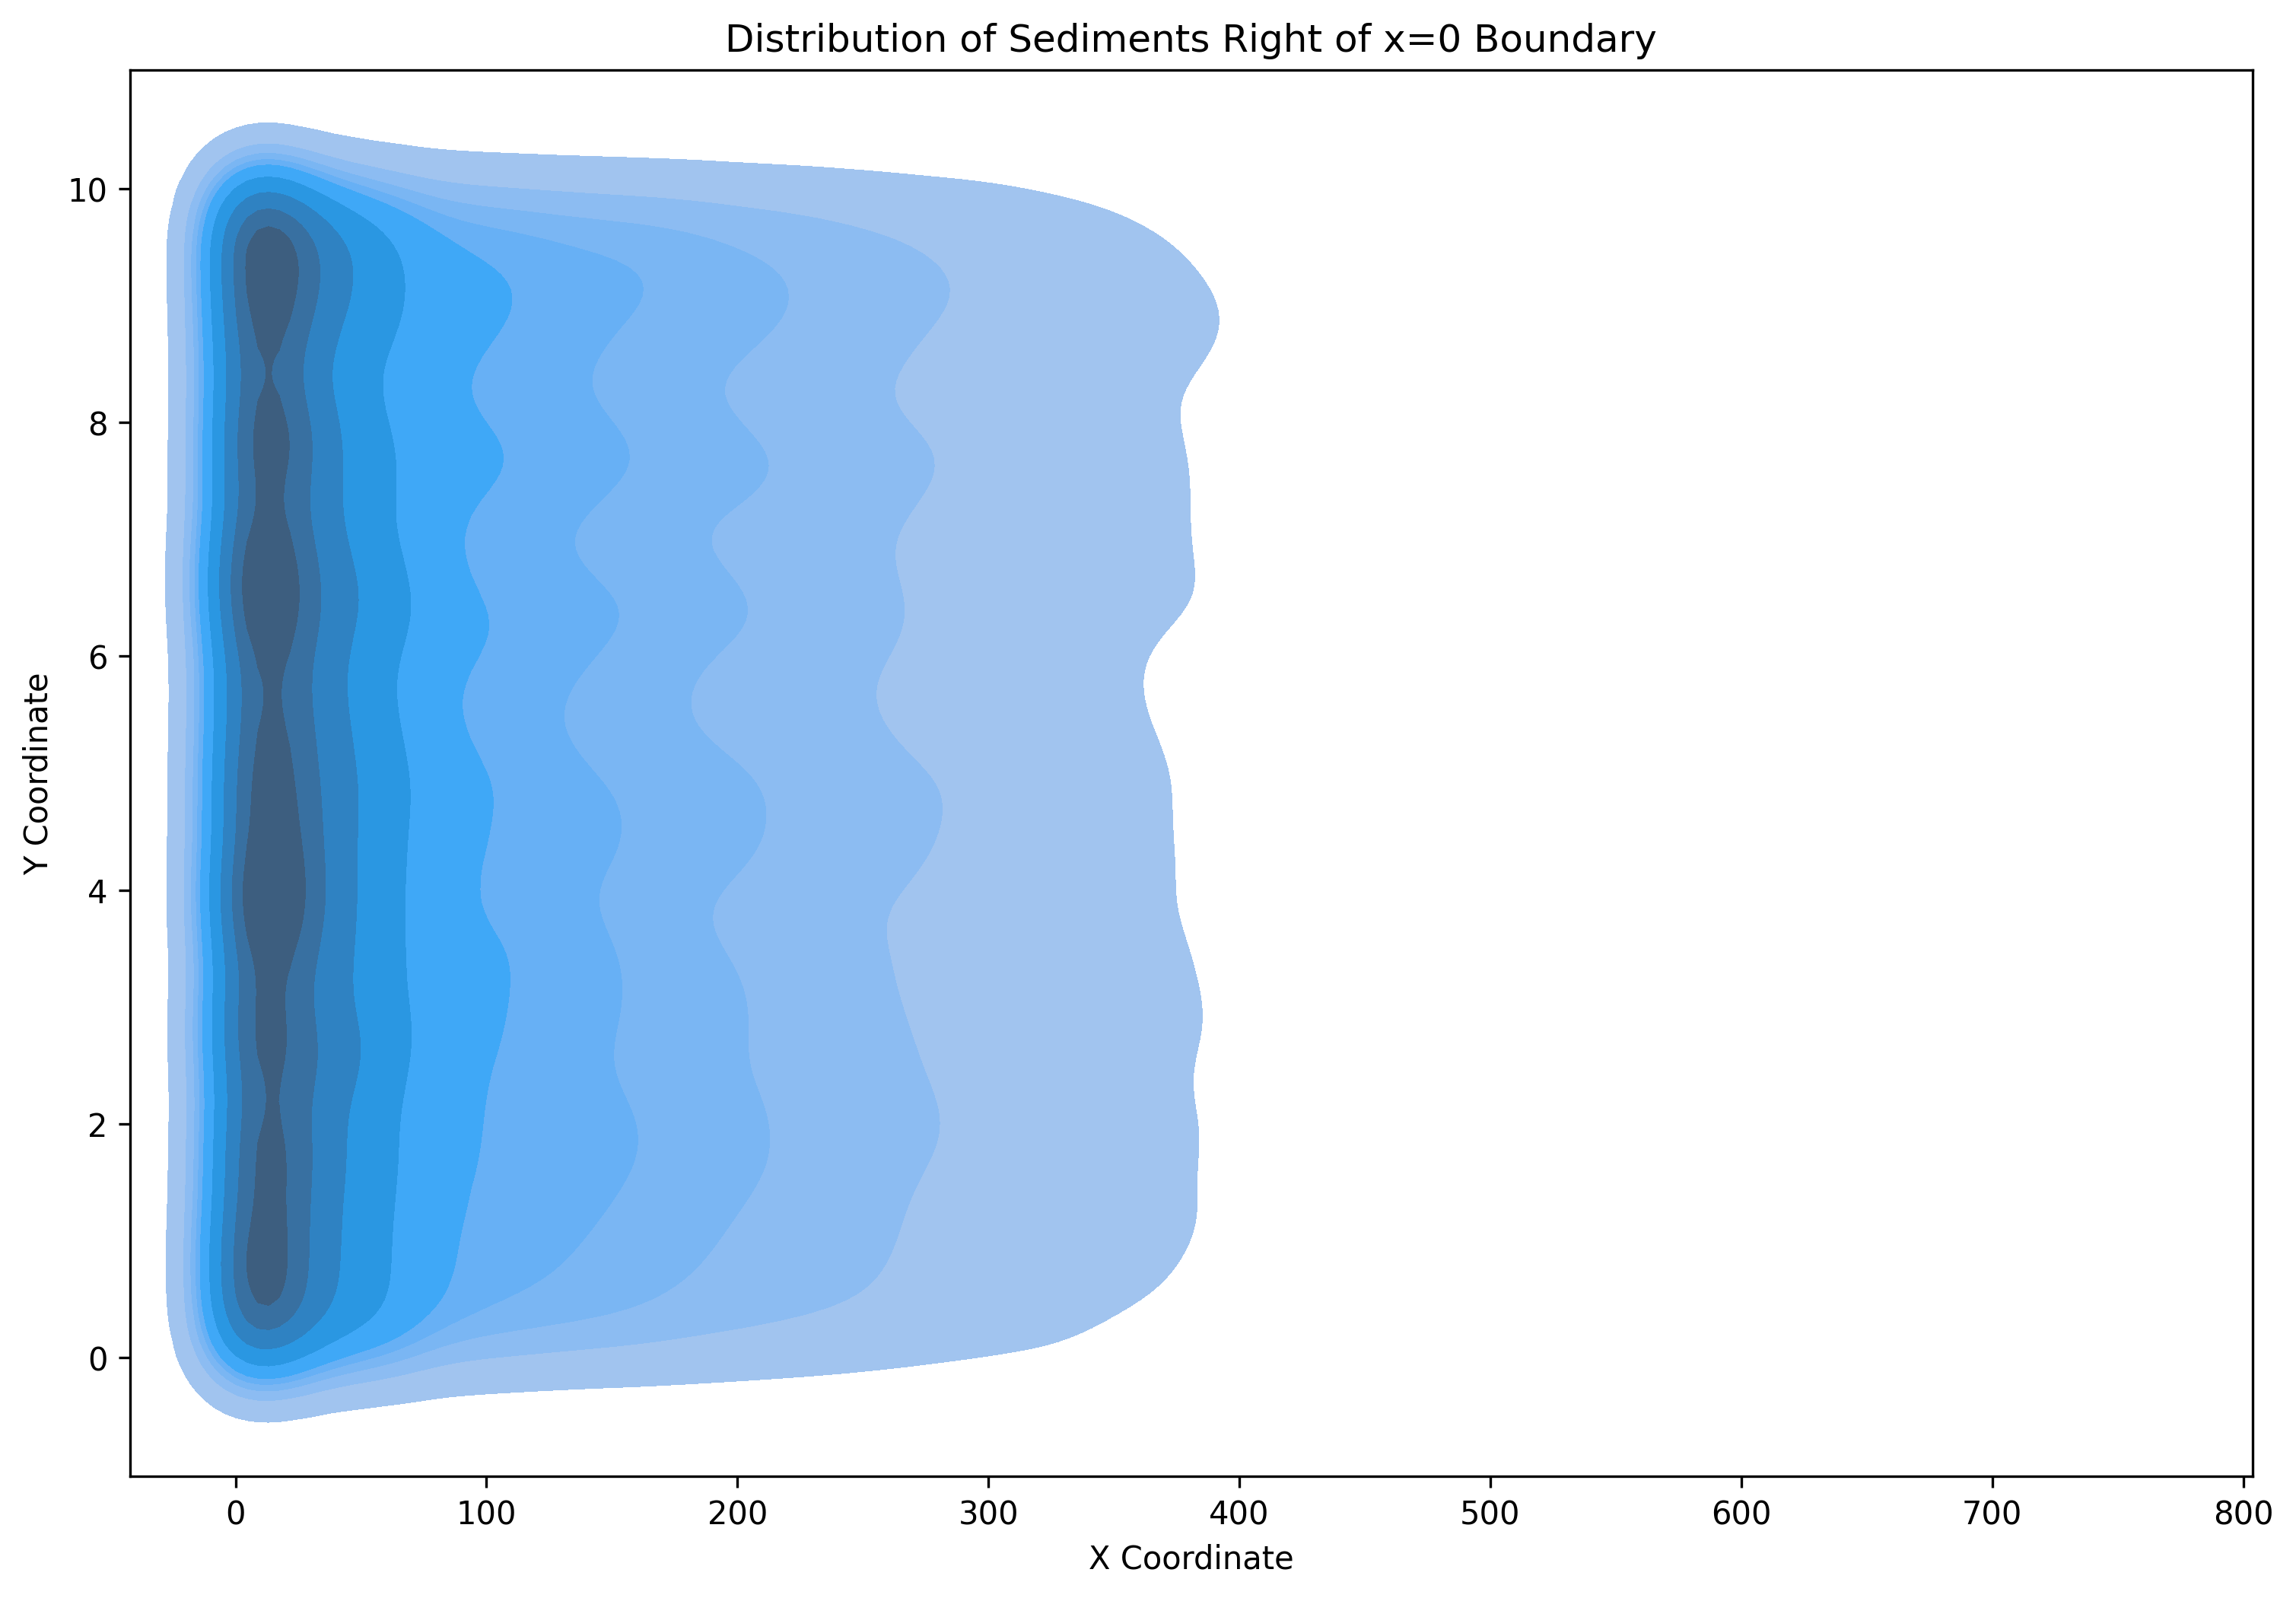

In [26]:
input_shear_stress_array = sampled_array
_, x_coordinates_all_iterations, y_coordinates_all_iterations, _ = hkm(input_shear_stress_array)

# Concatenating all the x and y coordinates across iterations
x_coordinates = []
y_coordinates = []

for x_iter, y_iter in zip(x_coordinates_all_iterations, y_coordinates_all_iterations):
    x_coordinates.extend(x_iter)
    y_coordinates.extend(y_iter)

# Filtering coordinates where x > 0
x_right_of_boundary = [x for x, y in zip(x_coordinates, y_coordinates) if x > 0]
y_right_of_boundary = [y for x, y in zip(x_coordinates, y_coordinates) if x > 0]

# Creating a DataFrame for seaborn
import pandas as pd
data = pd.DataFrame({'x': x_right_of_boundary, 'y': y_right_of_boundary})

# Plotting the KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data, x='x', y='y', fill=True)
plt.title('Distribution of Sediments Right of x=0 Boundary')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()